In [313]:
!pwd

/home/peter/proj/allestm-train/jupyter


In [314]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np
import pandas as pd
import json
import pathlib
import math

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve

#mpl.rcParams['figure.dpi'] = 300
#sns.set_style("ticks")

sns.set()
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('Paired', 13)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


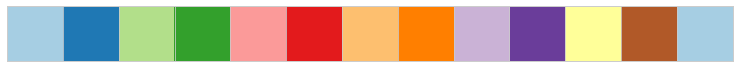

In [315]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

# Config

In [316]:
dataset_name = 'depth'
kind = 'test'#'test' / 'independent_test'
plot_dir = pathlib.Path('../plots/')
file_format = 'png'
savefig_args = {'dpi': 300, 'bbox_inches':'tight'}
two_col_fig_width = 7.5
one_col_fig_width = 3.5

method_mapping = [
    ['observed', 'Observed'],
    ['rf_', 'RF'],
    ['xgb_', 'GBM'],
    ['cnn_', 'conv'],
    ['dcnn_', 'dconv'],
    ['lstm_', 'LSTM'],
    ['blending', 'AllesTM'],
    ['profbval', 'PROFbval'],
    ['spinex', 'SPINE X'],
    ['anglor', 'ANGLOR'],
    ['predyflexy', 'PredyFlexy'],
    ['memsat', 'MEMSAT-SVM'],
    ['polyphobius', 'PolyPhobius'],
    ['prof', 'PROFphd'],
    ['psipred', 'PSIPRED']
]

# Raw data

In [317]:
conn = sqlite3.connect("../data.db")

In [318]:
raw_df = pd.read_sql_query(f"select * from raw_data join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) join proteins using (id)", conn)

In [319]:
raw_df.describe()

,resi,bfactor,phi,psi,acc_chain,acc_complex,tms_nr,re_nr,n_x,n_y,...,c_x,c_y,c_z,length,thickness,resolution,cov_total,cov_trimmed,num_tms,num_res
count,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.00000,56089.000000,56089.000000,...,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.000000,56089.0,56089.000000,56089.000000
mean,208.356237,76.658649,-1.200025,-0.004692,0.321574,0.268685,0.933427,-0.95500,1.141074,1.450618,...,1.129061,1.455702,-4.084774,417.712475,15.109460,2.777858,96.845847,100.0,7.265471,0.867710
std,175.068148,47.247210,0.729823,1.316982,0.265701,0.251495,3.104775,0.31908,19.701444,17.020057,...,19.710211,17.016847,28.809420,219.829738,0.818853,0.527638,3.505943,0.0,4.145765,1.126726
min,0.000000,-4.780000,-3.137710,-3.141232,0.000000,0.000000,-1.000000,-1.00000,-73.666000,-75.028999,...,-74.065002,-74.397003,-122.847000,37.000000,11.500000,1.150000,81.382979,100.0,1.000000,0.000000
25%,79.000000,41.810000,-1.428136,-0.783649,0.070423,0.038462,-1.000000,-1.00000,-11.711000,-9.046000,...,-11.735000,-9.034000,-19.430000,269.000000,14.700000,2.400000,95.112782,100.0,4.000000,0.000000
50%,166.000000,65.930000,-1.156551,-0.611555,0.285714,0.201220,-1.000000,-1.00000,0.891000,0.548000,...,0.905000,0.541000,-2.973000,366.000000,15.100000,2.850000,97.959184,100.0,7.000000,0.000000
75%,287.000000,100.440000,-1.037116,0.247370,0.526627,0.452381,2.000000,-1.00000,13.242000,10.547000,...,13.205000,10.568000,13.888000,506.000000,15.500000,3.200000,99.713467,100.0,11.000000,1.000000
max,1045.000000,409.280000,3.133032,3.140863,1.000000,1.000000,15.000000,3.00000,82.933998,95.122002,...,83.083000,95.275002,96.942001,1046.000000,17.800000,3.500000,100.000000,100.0,16.000000,4.000000


In [320]:
proteins_df = pd.read_sql_query(f"select * from (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a join proteins using (id)", conn)

In [321]:
proteins_df.describe()

,length,thickness,resolution,cov_total,cov_trimmed,num_tms,num_res
count,178.000000,178.000000,178.000000,178.000000,178.0,178.000000,178.000000
mean,315.106742,15.083989,2.724888,96.485166,100.0,5.870787,0.752809
std,180.317563,0.880475,0.526556,3.948667,0.0,3.954564,1.065970
min,37.000000,11.500000,1.150000,81.382979,100.0,1.000000,0.000000
25%,194.500000,14.700000,2.352500,94.896081,100.0,2.000000,0.000000
50%,282.500000,15.000000,2.800000,97.777869,100.0,5.500000,0.000000
75%,419.750000,15.575000,3.182500,99.713877,100.0,8.000000,1.000000
max,1046.000000,17.800000,3.500000,100.000000,100.0,16.000000,4.000000


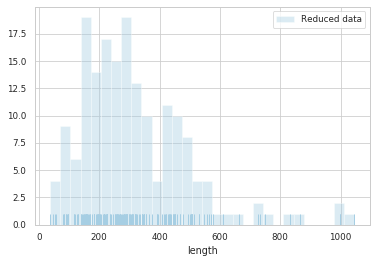

In [322]:
sns.distplot(proteins_df.length, kde=False, rug=True, bins=30, label="Reduced data")
#sns.distplot(pd.read_sql_query("select * from proteins", conn).length, kde=True, label="Original data")
plt.legend()

# Benchmark helper functions

## Measures

In [323]:
def exp2name(exp):
    for m, name in method_mapping:
        if exp.lower().startswith(m):
            return name
    return f'MISSING {exp}'

def exp2order(exp):
    for i, (m, name) in enumerate(method_mapping):
        if exp.lower().startswith(m):
            return i
    return f'MISSING {exp}'

In [324]:
def measures_cont(df, filename=None):
    measures = [pearsonr, mean_absolute_error, mean_squared_error, lambda x, y: math.sqrt(mean_squared_error(x, y))]
    measure_names = ['r', 'MAE', 'MSE', 'RMSE']
    obs = df[df.experiment == "observed"].val_0
    benchmarks = {}
    experiments = df[df.experiment != "observed"].experiment.unique()
    for experiment in sorted(experiments, key=exp2order):
        pred = df[df.experiment == experiment].val_0
        for i, measure in enumerate(measures):
            result = measure(obs, pred)
            if isinstance(result, list) or isinstance(result, tuple):
               
                if not measure_names[i] in benchmarks:
                    benchmarks[measure_names[i]] = []
                benchmarks[measure_names[i]].append(round(result[i], 2))
                #for i in range(len(result)):
                #    if not "{}_{}".format(measure.__name__, i) in benchmarks:
                #        benchmarks["{}_{}".format(measure.__name__, i)] = []
                #    benchmarks["{}_{}".format(measure.__name__, i)].append(round(result[i], 3))
            else:
                if not measure_names[i] in benchmarks:
                    benchmarks[measure_names[i]] = []
                benchmarks[measure_names[i]].append(round(result, 2))
    
    result = pd.DataFrame(benchmarks, index=[exp2name(x) for x in sorted(experiments, key=exp2order)])
    if filename is not None:
        result.to_csv(plot_dir / f'{dataset_name}_{kind}_{filename}.csv')
    return result.style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")
    #return pd.DataFrame(benchmarks, index=[exp2name(x) for x in experiments]).sort_values(by="MAE").style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")

In [325]:
def measures_bin(df, filename=None):
    measures = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef]
    measure_names = ['ACC', 'P', 'R', 'F1', 'AUC', 'MCC']
    obs = df[df.experiment == "observed"].val_0
    benchmarks = {measure: [] for measure in measure_names}
    experiments = df[df.experiment != "observed"].experiment.unique()
    for experiment in sorted(experiments, key=exp2order):
        pred = df[df.experiment == experiment].val_0.round()
        for i, measure in enumerate(measures):
            benchmarks[measure_names[i]].append(round(measure(obs, pred), 2))
    result = pd.DataFrame(benchmarks, index=[exp2name(x) for x in sorted(experiments, key=exp2order)])
    if filename is not None:
        result.to_csv(plot_dir / f'{dataset_name}_{kind}_{filename}.csv')
    return result.style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")
    #return pd.DataFrame(benchmarks, index=[exp2name(x) for x in experiments]).sort_values(by="ACC", ascending=False).style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")

In [326]:
def measures_cat(df, num_classes=3, class_names=None, filename=None):
    if class_names is None:
        class_names = [i for i in range(num_classes)]
        
    measures_all = [accuracy_score]
    measures_class = [precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef]
    measure_all_names = ['ACC']
    measure_names = ['P', 'R', 'F1', 'AUC', 'MCC']
    
    obs = df[df.experiment == "observed"][["val_{}".format(x) for x in range(num_classes)]]
    
    #benchmarks = {measure.__name__: [] for measure in measures_all + measures_class}
    benchmarks = {measure: [] for measure in measure_all_names}
    experiments = df[df.experiment != "observed"].experiment.unique()
    for experiment in sorted(experiments, key=exp2order):
        pred = df[df.experiment == experiment][["val_{}".format(x) for x in range(num_classes)]]
        pred_argmax = np.array(pred).argmax(axis=1)
        for i, measure in enumerate(measures_all):
            benchmarks[measure_all_names[i]].append(round(measure(np.array(obs).argmax(axis=1), pred_argmax), 2))
        
        obs_rounded = np.array(obs)
        pred_rounded = np.zeros(pred.shape)
        for i, argmax in enumerate(pred_argmax):
            pred_rounded[i, argmax] = 1
           
        
            
            #class_results = []
        for i in range(num_classes):
            for m, measure in enumerate(measures_class):
                if not "{} ({})".format(class_names[i], measure_names[m]) in benchmarks:
                    benchmarks["{} ({})".format(class_names[i], measure_names[m])] = []
                benchmarks["{} ({})".format(class_names[i], measure_names[m])].append(round(measure(obs_rounded[:, i], pred_rounded[:, i]), 2))
                #class_results.append(round(measure(obs_rounded[:, i], pred_rounded[:, i]), 3))
            #benchmarks[measure.__name__].append(class_results)
        
    result = pd.DataFrame(benchmarks, index=[exp2name(x) for x in sorted(experiments, key=exp2order)])
    if filename is not None:
        result.to_csv(plot_dir / f'{dataset_name}_{kind}_{filename}.csv')
    return result.style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")
    #return pd.DataFrame(benchmarks, index=[exp2name(x) for x in experiments]).sort_values(by="ACC", ascending=False).style.highlight_min(axis=0, color="yellow").highlight_max(axis=0, color="orange")

<h2>Plots</h2>

In [327]:
def plots_cont(df, xlab, ylab, filename=None, hist=False, kde=True):
    fig, ax = plt.subplots(1, 1, figsize=(one_col_fig_width, one_col_fig_width))
    #min_val = df.val_0.min()
    #max_val = df.val_0.max()
    #axs[1].set(xlim=(min_val, max_val), ylim=(min_val, max_val))
    for experiment in sorted(df.experiment.unique(), key=exp2order):
        kde_kws = {}
        color = None
        if experiment == "observed":
            #hist = True
            color='black'
            kde_kws["lw"] = 4
        else:
            pass
            #sns.kdeplot(df[df.experiment == 'observed'].val_0, df[df.experiment == experiment].val_0, label=experiment, ax=axs[1])
            #sns.regplot(df[df.experiment == 'observed'].val_0, df[df.experiment == experiment].val_0, label=experiment, ax=axs[1], scatter=False)
        sns.distplot(df[df.experiment == experiment].val_0, label=exp2name(experiment), hist=hist, kde=kde, color=color, ax=ax, kde_kws=kde_kws)
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.legend(frameon=True, facecolor='white', framealpha=0.8)
    #axs[1].set(xlabel='Observed', ylabel='Predicted')
    #axs[1].legend()
    if filename is not None:
        fig.savefig(plot_dir / f'{dataset_name}_{kind}_{filename}.{file_format}', **savefig_args)

In [328]:
def plots_bin(obs_df, dfs, filename=None):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(two_col_fig_width, two_col_fig_width/2)
    for a in ax:
        a.set_xlim([0, 1])
        a.set_ylim([0, 1])
    
    obs = obs_df[obs_df.experiment == "observed"].val_0
    
    for name, df in dfs.items():
        for experiment in sorted(df[df.experiment != "observed"].experiment.unique(), key=exp2order):
            pr = precision_recall_curve(obs, df[df.experiment == experiment].val_0)
            ax[0].plot(pr[1], pr[0], label=exp2name(experiment))

            roc = roc_curve(obs, df[df.experiment == experiment].val_0)
            ax[1].plot(roc[0], roc[1], label=exp2name(experiment))

    ax[0].set(xlabel="Recall", ylabel="Precision")
    #ax[0].legend()
    ax[1].set(xlabel="FPR or (1 - specificity)", ylabel="TPR or sensitivity")
    ax[1].legend(frameon=True, facecolor='white', framealpha=0.8)
    if filename is not None:
        fig.savefig(plot_dir / f'{dataset_name}_{kind}_{filename}.{file_format}', **savefig_args)

In [329]:
def plots_cat(obs_df, dfs, num_classes=3, filename=None, class_names=None):
    fig, ax = plt.subplots(num_classes, 2)
    fig.set_size_inches(two_col_fig_width, two_col_fig_width / 2 * num_classes)
    for a in ax:
        for b in a:
            b.set_xlim([0, 1])
            b.set_ylim([0, 1])
            
    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]
    
    obs_rounded = obs_df[obs_df.experiment == "observed"][["val_{}".format(x) for x in range(num_classes)]].values
    
    for name, df in dfs.items():
        for experiment in sorted(df[df.experiment != "observed"].experiment.unique(), key=exp2order):
            pred = df[df.experiment == experiment][["val_{}".format(x) for x in range(num_classes)]]
            pred_argmax = np.array(pred).argmax(axis=1)
            
            pred_rounded = pred.values
            #pred_rounded = np.zeros(pred.shape)
            #for i, argmax in enumerate(pred_argmax):
            #    pred_rounded[i, argmax] = 1
                
            for i in range(num_classes):
                pr = precision_recall_curve(obs_rounded[:, i], pred_rounded[:, i])
                ax[i][0].plot(pr[1], pr[0], label=exp2name(experiment))

                roc = roc_curve(obs_rounded[:, i], pred_rounded[:, i])
                ax[i][1].plot(roc[0], roc[1], label=exp2name(experiment))

                ax[i][0].set(xlabel="Recall", ylabel="Precision")
                ax[i][1].set(xlabel="FPR or (1 - specificity)", ylabel="TPR or sensitivity")
                #ax[i][0].legend()
                if i == 0:
                    ax[i][1].legend(frameon=True, facecolor='white', framealpha=0.8)
                    
                ax[i][0].annotate(class_names[i], (0.1, 0.1), horizontalalignment='center', verticalalignment='center', fontsize='xx-large')
                
    if filename is not None:
        fig.savefig(plot_dir / f'{dataset_name}_{kind}_{filename}.{file_format}', **savefig_args)

<h1>Bfactors</h1>

<h2>Bfactors continuous</h2>

In [330]:
bfactors_cont = pd.read_sql_query(f"select * from mllib_features_continuous_bfactors join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [331]:
bfactors_cont.groupby("experiment").describe()

resi                                            \
                          count        mean         std  min   25%    50%   
experiment                                                                  
blending_bfactors_cont  56089.0  208.356237  175.068148  0.0  79.0  166.0   
cnn_domain_bfactors     56089.0  208.356237  175.068148  0.0  79.0  166.0   
dcnn_domain_bfactors    56089.0  208.356237  175.068148  0.0  79.0  166.0   
lstm_domain_bfactors    56089.0  208.356237  175.068148  0.0  79.0  166.0   
observed                56089.0  208.356237  175.068148  0.0  79.0  166.0   
predyflexy              56089.0  208.356237  175.068148  0.0  79.0  166.0   
profbval_bnorm          56089.0  208.356237  175.068148  0.0  79.0  166.0   
rf_bfactors_cont        56089.0  208.356237  175.068148  0.0  79.0  166.0   
xgb_bfactors_cont       56089.0  208.356237  175.068148  0.0  79.0  166.0   

                                         val_0                          \
                          75%     max    count          mean       std   
experiment                                                               
blending_bfactors_cont  287.0  1045.0  56089.0 -5.595746e-03  0.491630   
cnn_domain_bfactors     287.0  1045.0  56089.0 -1.543209e-01  0.456859   
dcnn_domain_bfactors    287.0  1045.0  56089.0 -1.273631e-01  0.496556   
lstm_domain_bfactors    287.0  1045.0  56089.0 -1.239246e-01  0.446875   
observed                287.0  1045.0  56089.0 -4.256492e-17  1.000009   
predyflexy              287.0  1045.0  56089.0  1.745902e-01  0.412062   
profbval_bnorm          287.0  1045.0  56089.0  1.160263e-02  0.872344   
rf_bfactors_cont        287.0  1045.0  56089.0  3.268684e-02  0.428898   
xgb_bfactors_cont       287.0  1045.0  56089.0  7.570713e-03  0.476231   

                                                                          
                             min       25%       50%       75%       max  
experiment                                                                
blending_bfactors_cont -1.103178 -0.371627 -0.125074  0.274197  3.219063  
cnn_domain_bfactors    -1.096233 -0.469583 -0.267526  0.053075  3.799506  
dcnn_domain_bfactors   -1.342746 -0.484795 -0.261265  0.134340  3.139653  
lstm_domain_bfactors   -1.092372 -0.453016 -0.250786  0.134474  3.002503  
observed               -3.849002 -0.692366 -0.215190  0.483948  8.425018  
predyflexy             -0.702000 -0.171000  0.129000  0.503000  1.551000  
profbval_bnorm         -2.340000 -0.670000 -0.060000  0.590000  4.960000  
rf_bfactors_cont       -0.932376 -0.304574 -0.045962  0.297368  2.653662  
xgb_bfactors_cont      -1.228203 -0.356645 -0.084141  0.295539  3.310239

<h3>Benchmark measures</h3>

In [332]:
measures_cont(bfactors_cont, filename='bfactors_cont')

,r,MAE,MSE,RMSE
RF,0.42,0.69,0.82,0.91
GBM,0.44,0.67,0.81,0.9
conv,0.45,0.66,0.82,0.91
dconv,0.46,0.66,0.8,0.9
LSTM,0.45,0.66,0.81,0.9
AllesTM,0.48,0.66,0.77,0.88
PROFbval,0.43,0.77,1,1
PredyFlexy,0.14,0.81,1.08,1.04


<h3>Benchmark plots</h3>

No handles with labels found to put in legend.


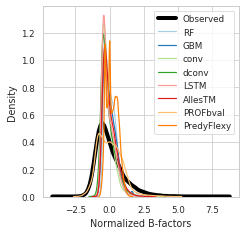

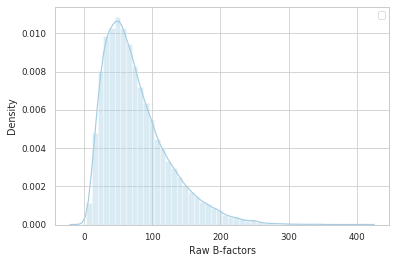

In [333]:
plots_cont(bfactors_cont, "Normalized B-factors", "Density", filename='bfactors_cont')

fig, ax = plt.subplots()
#fig.set_size_inches(11.7, 8.27)
sns.distplot(raw_df.bfactor, ax=ax)
ax.set(xlabel="Raw B-factors", ylabel="Density")
ax.legend()

<h2>Bfactors binary</h2>

In [334]:
bfactors_bin = pd.read_sql_query(f"select * from mllib_features_binary_bfactors join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [335]:
bfactors_bin.groupby("experiment").describe()

resi                                            \
                         count        mean         std  min   25%    50%   
experiment                                                                 
blending_bfactors_bin  56089.0  208.356237  175.068148  0.0  79.0  166.0   
cnn_domain_bfactors    56089.0  208.356237  175.068148  0.0  79.0  166.0   
dcnn_domain_bfactors   56089.0  208.356237  175.068148  0.0  79.0  166.0   
lstm_domain_bfactors   56089.0  208.356237  175.068148  0.0  79.0  166.0   
observed               56089.0  208.356237  175.068148  0.0  79.0  166.0   
profbval_strict        56089.0  208.356237  175.068148  0.0  79.0  166.0   
rf_bfactors_bin        56089.0  208.356237  175.068148  0.0  79.0  166.0   
xgb_bfactors_bin       56089.0  208.356237  175.068148  0.0  79.0  166.0   

                                        val_0                                \
                         75%     max    count      mean       std       min   
experiment                                                                    
blending_bfactors_bin  287.0  1045.0  56089.0  0.395410  0.198830  0.091331   
cnn_domain_bfactors    287.0  1045.0  56089.0  0.387887  0.198951  0.035905   
dcnn_domain_bfactors   287.0  1045.0  56089.0  0.396642  0.228435  0.014727   
lstm_domain_bfactors   287.0  1045.0  56089.0  0.387424  0.210612  0.028741   
observed               287.0  1045.0  56089.0  0.394801  0.488812  0.000000   
profbval_strict        287.0  1045.0  56089.0  0.123803  0.329360  0.000000   
rf_bfactors_bin        287.0  1045.0  56089.0  0.401576  0.165391  0.046517   
xgb_bfactors_bin       287.0  1045.0  56089.0  0.378952  0.239713  0.001183   

                                                               
                            25%       50%       75%       max  
experiment                                                     
blending_bfactors_bin  0.224262  0.344120  0.550001  0.908662  
cnn_domain_bfactors    0.227173  0.348747  0.524207  0.999389  
dcnn_domain_bfactors   0.204699  0.344843  0.573466  0.991507  
lstm_domain_bfactors   0.205417  0.351212  0.554042  0.982870  
observed               0.000000  0.000000  1.000000  1.000000  
profbval_strict        0.000000  0.000000  0.000000  1.000000  
rf_bfactors_bin        0.265249  0.387237  0.522788  0.943333  
xgb_bfactors_bin       0.173773  0.335818  0.562261  0.992014

<h3>Benchmark measures</h3>

In [336]:
measures_bin(bfactors_bin, filename='bfactors_bin')

,ACC,P,R,F1,AUC,MCC
RF,0.68,0.62,0.46,0.53,0.64,0.3
GBM,0.67,0.6,0.48,0.53,0.64,0.29
conv,0.68,0.64,0.45,0.53,0.64,0.31
dconv,0.68,0.62,0.5,0.56,0.65,0.31
LSTM,0.68,0.62,0.49,0.55,0.65,0.31
AllesTM,0.69,0.63,0.49,0.55,0.65,0.32
PROFbval,0.65,0.68,0.21,0.32,0.57,0.22


<h3>Benchmark curves</h3>

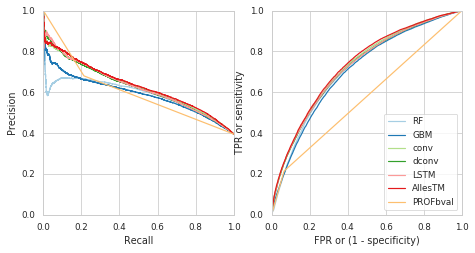

In [337]:
plots_bin(bfactors_bin, {"bin": bfactors_bin}, filename='bfactors_bin')

# Bfactors - TMS

<h2>Bfactors continuous</h2>

In [338]:
bfactors_cont_tms = pd.read_sql_query(f"select p.experiment, p.id, p.resi, p.val_0 from mllib_features_continuous_bfactors as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo='T' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [339]:
bfactors_cont_tms.groupby("experiment").describe()

resi                                           \
                          count       mean         std  min   25%    50%   
experiment                                                                 
blending_bfactors_cont  23083.0  193.13876  168.176584  0.0  70.0  152.0   
cnn_domain_bfactors     23083.0  193.13876  168.176584  0.0  70.0  152.0   
dcnn_domain_bfactors    23083.0  193.13876  168.176584  0.0  70.0  152.0   
lstm_domain_bfactors    23083.0  193.13876  168.176584  0.0  70.0  152.0   
observed                23083.0  193.13876  168.176584  0.0  70.0  152.0   
predyflexy              23083.0  193.13876  168.176584  0.0  70.0  152.0   
profbval_bnorm          23083.0  193.13876  168.176584  0.0  70.0  152.0   
rf_bfactors_cont        23083.0  193.13876  168.176584  0.0  70.0  152.0   
xgb_bfactors_cont       23083.0  193.13876  168.176584  0.0  70.0  152.0   

                                         val_0                                \
                          75%     max    count      mean       std       min   
experiment                                                                     
blending_bfactors_cont  269.0  1028.0  23083.0 -0.221454  0.352485 -1.103178   
cnn_domain_bfactors     269.0  1028.0  23083.0 -0.325013  0.330937 -1.096233   
dcnn_domain_bfactors    269.0  1028.0  23083.0 -0.335935  0.364184 -1.270384   
lstm_domain_bfactors    269.0  1028.0  23083.0 -0.309521  0.319227 -0.982179   
observed                269.0  1028.0  23083.0 -0.269401  0.784948 -2.466640   
predyflexy              269.0  1028.0  23083.0  0.054806  0.388582 -0.698000   
profbval_bnorm          269.0  1028.0  23083.0 -0.604323  0.578528 -2.340000   
rf_bfactors_cont        269.0  1028.0  23083.0 -0.220413  0.306449 -0.846924   
xgb_bfactors_cont       269.0  1028.0  23083.0 -0.250745  0.342323 -1.228203   

                                                                
                             25%       50%       75%       max  
experiment                                                      
blending_bfactors_cont -0.459929 -0.301699 -0.071110  2.524163  
cnn_domain_bfactors    -0.538045 -0.390462 -0.203242  2.050767  
dcnn_domain_bfactors   -0.562547 -0.416607 -0.204040  2.078166  
lstm_domain_bfactors   -0.522395 -0.393043 -0.184926  1.942102  
observed               -0.793918 -0.401343  0.106938  6.671468  
predyflexy             -0.311000  0.000000  0.348000  1.485000  
profbval_bnorm         -0.960000 -0.690000 -0.310000  4.150000  
rf_bfactors_cont       -0.411934 -0.298985 -0.109552  2.164961  
xgb_bfactors_cont      -0.475305 -0.328023 -0.107136  2.271925

<h3>Benchmark measures</h3>

In [340]:
measures_cont(bfactors_cont_tms, filename='bfactors_cont_tms')

,r,MAE,MSE,RMSE
RF,0.3,0.57,0.57,0.75
GBM,0.35,0.55,0.55,0.74
conv,0.39,0.54,0.53,0.73
dconv,0.38,0.55,0.54,0.73
LSTM,0.38,0.54,0.53,0.73
AllesTM,0.41,0.55,0.51,0.72
PROFbval,0.25,0.68,0.84,0.92
PredyFlexy,0.04,0.74,0.85,0.92


<h3>Benchmark plots</h3>

No handles with labels found to put in legend.


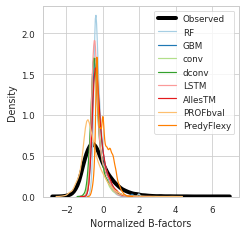

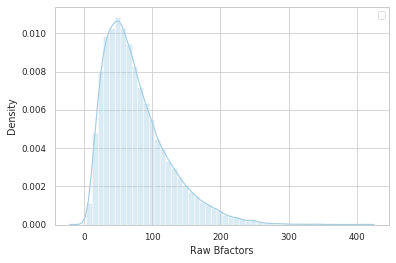

In [341]:
plots_cont(bfactors_cont_tms, "Normalized B-factors", "Density", filename='bfactors_cont_tms')

fig, ax = plt.subplots()
#fig.set_size_inches(11.7, 8.27)
sns.distplot(raw_df.bfactor, ax=ax)
ax.set(xlabel="Raw Bfactors", ylabel="Density")
ax.legend()

<h2>Bfactors binary</h2>

In [342]:
bfactors_bin_tms = pd.read_sql_query(f"select p.experiment, p.id, p.resi, p.val_0 from mllib_features_binary_bfactors as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo='T' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [343]:
bfactors_bin_tms.groupby("experiment").describe()

resi                                           \
                         count       mean         std  min   25%    50%   
experiment                                                                
blending_bfactors_bin  23083.0  193.13876  168.176584  0.0  70.0  152.0   
cnn_domain_bfactors    23083.0  193.13876  168.176584  0.0  70.0  152.0   
dcnn_domain_bfactors   23083.0  193.13876  168.176584  0.0  70.0  152.0   
lstm_domain_bfactors   23083.0  193.13876  168.176584  0.0  70.0  152.0   
observed               23083.0  193.13876  168.176584  0.0  70.0  152.0   
profbval_strict        23083.0  193.13876  168.176584  0.0  70.0  152.0   
rf_bfactors_bin        23083.0  193.13876  168.176584  0.0  70.0  152.0   
xgb_bfactors_bin       23083.0  193.13876  168.176584  0.0  70.0  152.0   

                                        val_0                                \
                         75%     max    count      mean       std       min   
experiment                                                                    
blending_bfactors_bin  269.0  1028.0  23083.0  0.303991  0.156424  0.102227   
cnn_domain_bfactors    269.0  1028.0  23083.0  0.299973  0.161020  0.041634   
dcnn_domain_bfactors   269.0  1028.0  23083.0  0.290842  0.181285  0.019064   
lstm_domain_bfactors   269.0  1028.0  23083.0  0.293324  0.173323  0.031206   
observed               269.0  1028.0  23083.0  0.278863  0.448450  0.000000   
profbval_strict        269.0  1028.0  23083.0  0.007841  0.088205  0.000000   
rf_bfactors_bin        269.0  1028.0  23083.0  0.294504  0.124247  0.046517   
xgb_bfactors_bin       269.0  1028.0  23083.0  0.258008  0.186166  0.001183   

                                                               
                            25%       50%       75%       max  
experiment                                                     
blending_bfactors_bin  0.188687  0.251196  0.373526  0.886439  
cnn_domain_bfactors    0.181996  0.261175  0.377078  0.971041  
dcnn_domain_bfactors   0.160383  0.237070  0.373575  0.951843  
lstm_domain_bfactors   0.159915  0.242034  0.393135  0.924202  
observed               0.000000  0.000000  1.000000  1.000000  
profbval_strict        0.000000  0.000000  0.000000  1.000000  
rf_bfactors_bin        0.204038  0.267317  0.362500  0.831323  
xgb_bfactors_bin       0.117640  0.206216  0.353337  0.970792

<h3>Benchmark measures</h3>

In [344]:
measures_bin(bfactors_bin_tms, filename='bfactors_bin_tms')

,ACC,P,R,F1,AUC,MCC
RF,0.73,0.54,0.14,0.22,0.55,0.16
GBM,0.73,0.52,0.23,0.32,0.57,0.2
conv,0.74,0.56,0.24,0.34,0.59,0.23
dconv,0.73,0.54,0.27,0.36,0.59,0.24
LSTM,0.74,0.55,0.3,0.39,0.6,0.26
AllesTM,0.74,0.56,0.27,0.36,0.59,0.25
PROFbval,0.73,0.81,0.02,0.04,0.51,0.1


<h3>Benchmark curves</h3>

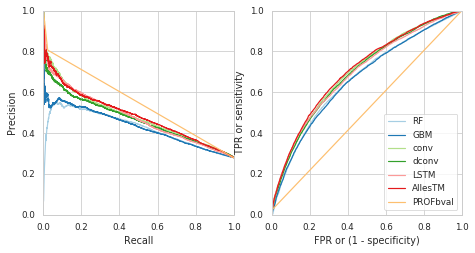

In [345]:
plots_bin(bfactors_bin_tms, {"bin": bfactors_bin_tms}, filename='bfactors_bin_tms')

<h1>Z-coordinates</h1>

<h2>Z-coordinates continuous</h2>

In [346]:
zcoords_cont = pd.read_sql_query(f"select * from mllib_features_continuous_ZCoordinates join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [347]:
zcoords_cont.groupby("experiment").describe()

resi                                            \
                         count        mean         std  min   25%    50%   
experiment                                                                 
blending_zcoords_cont  56089.0  208.356237  175.068148  0.0  79.0  166.0   
cnn_domain_zcoords     56089.0  208.356237  175.068148  0.0  79.0  166.0   
dcnn_domain_zcoords    56089.0  208.356237  175.068148  0.0  79.0  166.0   
lstm_domain_zcoords    56089.0  208.356237  175.068148  0.0  79.0  166.0   
observed               56089.0  208.356237  175.068148  0.0  79.0  166.0   
rf_zcoords_cont        56089.0  208.356237  175.068148  0.0  79.0  166.0   
xgb_zcoords_cont       56089.0  208.356237  175.068148  0.0  79.0  166.0   

                                        val_0                                  \
                         75%     max    count      mean        std        min   
experiment                                                                      
blending_zcoords_cont  287.0  1045.0  56089.0 -2.451262  16.316581 -28.063647   
cnn_domain_zcoords     287.0  1045.0  56089.0 -2.292684  15.794069 -25.000000   
dcnn_domain_zcoords    287.0  1045.0  56089.0 -2.600437  15.255540 -25.000000   
lstm_domain_zcoords    287.0  1045.0  56089.0 -2.498592  16.396688 -25.000000   
observed               287.0  1045.0  56089.0 -2.062678  17.718575 -25.000000   
rf_zcoords_cont        287.0  1045.0  56089.0 -2.290299   8.136408 -24.791314   
xgb_zcoords_cont       287.0  1045.0  56089.0 -1.957612   9.884047 -25.000000   

                                                                 
                             25%       50%        75%       max  
experiment                                                       
blending_zcoords_cont -18.478967 -3.227883  12.030143  28.21072  
cnn_domain_zcoords    -17.041752 -2.039078  11.074116  25.00000  
dcnn_domain_zcoords   -16.449077 -3.036488   9.950045  25.00000  
lstm_domain_zcoords   -18.777877 -3.377562  11.934154  25.00000  
observed              -19.094999 -2.985000  13.771000  25.00000  
rf_zcoords_cont        -7.594471 -2.004283   2.600464  24.53857  
xgb_zcoords_cont       -9.023476 -2.000000   4.565916  25.00000

<h3>Benchmark measures</h3>

In [348]:
measures_cont(zcoords_cont, filename='zcoords_cont')

,r,MAE,MSE,RMSE
RF,0.68,10.64,185.06,13.6
GBM,0.71,9.63,163.51,12.79
conv,0.73,6.94,155.87,12.48
dconv,0.81,6.02,106.98,10.34
LSTM,0.84,4.99,94.02,9.7
AllesTM,0.84,5.08,91.98,9.59


<h3>Benchmark plots</h3>

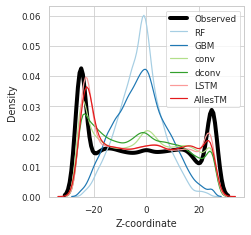

In [349]:
plots_cont(zcoords_cont, "Z-coordinate", "Density", filename='zcoords_cont')

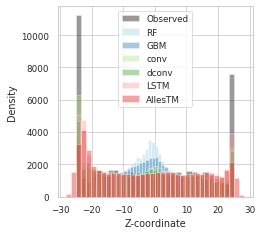

In [350]:
plots_cont(zcoords_cont, "Z-coordinate", "Density", filename='hist_zcoords_cont', hist=True, kde=False)

# Topology

In [351]:
zcoords_cat = pd.read_sql_query(f"select * from mllib_features_categorical_Topology join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [352]:
zcoords_cat.groupby("experiment").describe()

resi                                                   \
                       count        mean         std  min   25%    50%    75%   
experiment                                                                      
blending_topo        56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
cnn_domain_zcoords   56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
dcnn_domain_zcoords  56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
lstm_domain_zcoords  56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
memsat_svm           56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
observed             56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
polyphobius          56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
rf_topo              56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
xgb_topo             56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   

                               val_0            ...     val_2            \
                        max    count      mean  ...       75%       max   
experiment                                      ...                       
blending_topo        1045.0  56089.0  0.329234  ...  0.360745  0.990085   
cnn_domain_zcoords   1045.0  56089.0  0.326961  ...  0.430301  0.999458   
dcnn_domain_zcoords  1045.0  56089.0  0.331083  ...  0.406925  0.999984   
lstm_domain_zcoords  1045.0  56089.0  0.333088  ...  0.354425  0.999849   
memsat_svm           1045.0  56089.0  0.310899  ...  1.000000  1.000000   
observed             1045.0  56089.0  0.325447  ...  0.000000  1.000000   
polyphobius          1045.0  56089.0  0.297795  ...  1.000000  1.000000   
rf_topo              1045.0  56089.0  0.330504  ...  0.345714  0.937143   
xgb_topo             1045.0  56089.0  0.344428  ...  0.335604  0.999737   

                       val_3                                              \
                       count      mean       std           min       25%   
experiment                                                                 
blending_topo        56089.0  0.026992  0.059895  3.442178e-04  0.008953   
cnn_domain_zcoords   56089.0  0.021109  0.032737  2.019266e-06  0.002246   
dcnn_domain_zcoords  56089.0  0.023589  0.047208  2.789629e-07  0.001984   
lstm_domain_zcoords  56089.0  0.025265  0.058920  2.038216e-05  0.003957   
memsat_svm           56089.0  0.006347  0.079416  0.000000e+00  0.000000   
observed             56089.0  0.024853  0.155679  0.000000e+00  0.000000   
polyphobius          56089.0  0.000000  0.000000  0.000000e+00  0.000000   
rf_topo              56089.0  0.030126  0.027868  0.000000e+00  0.013750   
xgb_topo             56089.0  0.014116  0.031923  1.157891e-06  0.001474   

                                                   
                          50%       75%       max  
experiment                                         
blending_topo        0.014213  0.026879  0.939360  
cnn_domain_zcoords   0.008786  0.027287  0.758865  
dcnn_domain_zcoords  0.008032  0.025557  0.866070  
lstm_domain_zcoords  0.009203  0.022880  0.874232  
memsat_svm           0.000000  0.000000  1.000000  
observed             0.000000  0.000000  1.000000  
polyphobius          0.000000  0.000000  0.000000  
rf_topo              0.023750  0.037500  0.467143  
xgb_topo             0.004949  0.015419  0.922218  

[9 rows x 40 columns]

<h3>Benchmark measures</h3>

In [353]:
measures_cat(zcoords_cat, 4, class_names=['In', 'TMS', 'Out', 'RER'], filename='zcoords_cat')

/home/peter/.local/share/virtualenvs/allestm-train-3at1bVAs/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/peter/.local/share/virtualenvs/allestm-train-3at1bVAs/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/peter/.local/share/virtualenvs/allestm-train-3at1bVAs/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


,ACC,In (P),In (R),In (F1),In (AUC),In (MCC),TMS (P),TMS (R),TMS (F1),TMS (AUC),TMS (MCC),Out (P),Out (R),Out (F1),Out (AUC),Out (MCC),RER (P),RER (R),RER (F1),RER (AUC),RER (MCC)
RF,0.79,0.73,0.85,0.79,0.85,0.68,0.83,0.89,0.86,0.88,0.75,0.79,0.61,0.68,0.78,0.61,0.17,0,0.01,0.5,0.02
GBM,0.8,0.76,0.85,0.8,0.86,0.7,0.85,0.88,0.87,0.89,0.77,0.76,0.68,0.72,0.81,0.64,0.48,0.03,0.05,0.51,0.11
conv,0.8,0.79,0.82,0.8,0.86,0.7,0.86,0.88,0.87,0.89,0.78,0.73,0.75,0.74,0.83,0.65,0.56,0.01,0.02,0.5,0.07
dconv,0.83,0.83,0.86,0.84,0.89,0.76,0.87,0.88,0.87,0.89,0.79,0.78,0.79,0.79,0.86,0.72,0.41,0.03,0.06,0.52,0.11
LSTM,0.84,0.83,0.88,0.86,0.9,0.79,0.86,0.88,0.87,0.89,0.78,0.82,0.79,0.8,0.87,0.74,0.43,0.1,0.17,0.55,0.2
AllesTM,0.85,0.85,0.89,0.87,0.9,0.8,0.88,0.88,0.88,0.9,0.8,0.82,0.83,0.82,0.88,0.77,0.47,0.12,0.19,0.56,0.23
MEMSAT-SVM,0.73,0.72,0.69,0.7,0.78,0.56,0.88,0.82,0.85,0.87,0.75,0.56,0.71,0.63,0.77,0.5,0.54,0.14,0.22,0.57,0.27
PolyPhobius,0.76,0.77,0.7,0.73,0.8,0.61,0.87,0.84,0.85,0.87,0.75,0.61,0.78,0.68,0.81,0.58,0,0,0,0.5,0


<h3>Benchmark plots</h3>

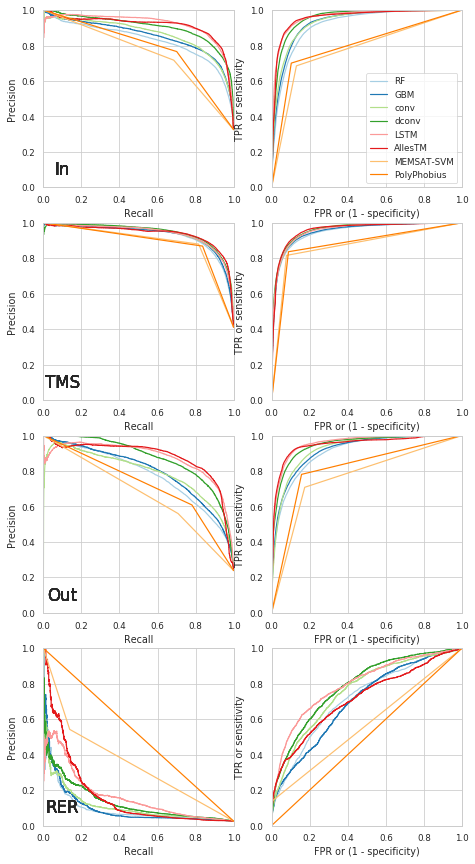

In [354]:
 plots_cat(zcoords_cat, {"cat": zcoords_cat}, num_classes=4, filename='zcoords_cat', class_names=['In', 'TMS', 'Out', 'RER'])

<h1>Phi angles</h2>

<h2>Phi angles continuous</h2>

In [355]:
phi_cont = pd.read_sql_query(f"select * from mllib_features_continuous_PhiAngles join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [356]:
phi_cont.groupby("experiment").describe()

resi                                                   \
                      count        mean         std  min   25%    50%    75%   
experiment                                                                     
anglor_phi          56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
blending_phi        56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
cnn_domain_angles   56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
dcnn_domain_angles  56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
lstm_domain_angles  56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
observed            56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
rf_phi              56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
spinex_phi          56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
xgb_phi             56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   

                              val_0                                    \
                       max    count       mean        std         min   
experiment                                                              
anglor_phi          1045.0  56089.0 -68.025759  25.723145 -120.400000   
blending_phi        1045.0  56089.0 -68.931802  24.341090 -138.570707   
cnn_domain_angles   1045.0  56089.0 -68.210101  26.846670 -170.598503   
dcnn_domain_angles  1045.0  56089.0 -67.946171  26.744707 -165.450518   
lstm_domain_angles  1045.0  56089.0 -68.083181  29.007035 -153.132849   
observed            1045.0  56089.0 -68.756361  41.815776 -179.777569   
rf_phi              1045.0  56089.0 -68.658955  20.066047 -122.784899   
spinex_phi          1045.0  56089.0 -70.681881  32.292953 -152.200000   
xgb_phi             1045.0  56089.0 -68.056663  20.741073 -130.679283   

                                                                 
                          25%        50%        75%         max  
experiment                                                       
anglor_phi         -76.700000 -65.400000 -62.600000  180.000000  
blending_phi       -78.320602 -67.768853 -63.978993  118.908627  
cnn_domain_angles  -77.470087 -65.575778 -62.118244  159.260291  
dcnn_domain_angles -75.169541 -64.619490 -62.600661  157.378399  
lstm_domain_angles -76.365119 -65.114744 -63.219742  130.635595  
observed           -81.826180 -66.265507 -59.422393  179.509493  
rf_phi             -77.705332 -70.112386 -65.112393   87.909769  
spinex_phi         -86.300000 -67.800000 -63.900000  106.100000  
xgb_phi            -77.430471 -68.815516 -63.480012  117.015992

<h3>Benchmark measures</h3>

In [357]:
measures_cont(phi_cont, filename='phi_cont')

,r,MAE,MSE,RMSE
RF,0.53,20.72,1259.5,35.49
GBM,0.54,20.4,1241.78,35.24
conv,0.53,19.44,1282.17,35.81
dconv,0.52,19.6,1299.52,36.05
LSTM,0.52,19.31,1319.27,36.32
AllesTM,0.57,19.13,1188.15,34.47
SPINE X,0.49,20.64,1474.41,38.4
ANGLOR,0.43,21.25,1492.83,38.64


<h3>Benchmark plots</h3>

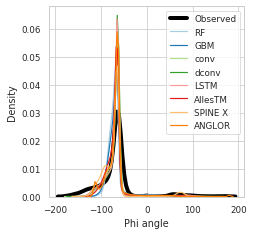

In [358]:
plots_cont(phi_cont, "Phi angle", "Density", filename='phi_cont')

<h1>Psi angles</h2>

<h2>Psi angles continuous</h2>

In [359]:
psi_cont = pd.read_sql_query(f"select * from mllib_features_continuous_PsiAngles join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [360]:
psi_cont.groupby("experiment").describe()

resi                                                   \
                      count        mean         std  min   25%    50%    75%   
experiment                                                                     
anglor_psi          56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
blending_psi        56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
cnn_domain_angles   56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
dcnn_domain_angles  56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
lstm_domain_angles  56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
observed            56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
rf_psi              56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
spinex_psi          56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
xgb_psi             56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   

                              val_0                                   \
                       max    count      mean        std         min   
experiment                                                             
anglor_psi          1045.0  56089.0  7.430537  56.439969 -179.700000   
blending_psi        1045.0  56089.0  0.104972  52.633762  -55.032722   
cnn_domain_angles   1045.0  56089.0 -2.188007  60.494695  -69.126577   
dcnn_domain_angles  1045.0  56089.0 -3.763702  60.516449 -106.249820   
lstm_domain_angles  1045.0  56089.0 -2.753435  62.155464  -52.411791   
observed            1045.0  56089.0 -0.268835  75.457515 -179.979332   
rf_psi              1045.0  56089.0 -0.195638  35.283667  -55.661461   
spinex_psi          1045.0  56089.0  6.658093  77.057137 -180.000000   
xgb_psi             1045.0  56089.0 -0.385851  42.820646  -87.868556   

                                                                 
                          25%        50%        75%         max  
experiment                                                       
anglor_psi         -35.400000 -16.200000  49.000000  180.000000  
blending_psi       -39.063700 -25.358050  24.615906  182.004506  
cnn_domain_angles  -41.776918 -35.520526  14.622964  180.000000  
dcnn_domain_angles -42.052376 -37.560035   8.963787  180.000000  
lstm_domain_angles -42.013339 -37.428907   3.042713  173.496062  
observed           -44.899802 -35.039527  14.173246  179.958194  
rf_psi             -30.714408  -7.474712  23.275529  134.893740  
spinex_psi         -40.000000 -33.400000   7.200000  180.000000  
xgb_psi            -36.273487 -13.187789  26.777228  180.000000

<h3>Benchmark measures</h3>

In [361]:
measures_cont(psi_cont, filename='psi_cont')

,r,MAE,MSE,RMSE
RF,0.61,42.91,3710.94,60.92
GBM,0.64,39.37,3365.24,58.01
conv,0.65,33.21,3465.95,58.87
dconv,0.62,34.24,3711.37,60.92
LSTM,0.62,33.25,3709.67,60.91
AllesTM,0.69,33.57,3021.61,54.97
SPINE X,0.52,39.76,5596.51,74.81
ANGLOR,0.61,40.47,3711.86,60.93


<h3>Benchmark plots</h3>

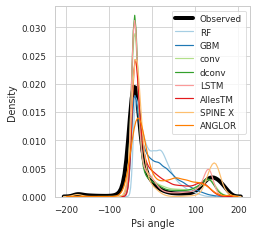

In [362]:
plots_cont(psi_cont, "Psi angle", "Density", filename='psi_cont')

In [363]:
#sns.kdeplot(phi_cont[phi_cont.experiment == 'observed'].val_0.values, psi_cont[psi_cont.experiment == 'observed'].val_0.values)

# Secondary structure

In [364]:
sec_cat = pd.read_sql_query(f"select * from mllib_features_categorical_SecStruc join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [365]:
sec_cat.groupby("experiment").describe()

resi                                                   \
                count        mean         std  min   25%    50%    75%   
experiment                                                               
blending_sec  56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
cnn_sec       56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
dcnn_sec      56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
lstm_sec      56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
observed      56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
prof          56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
psipred       56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
rf_sec        56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
spinex_sec    56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
xgb_sec       56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   

                        val_0            ...     val_1              val_2  \
                 max    count      mean  ...       75%       max    count   
experiment                               ...                                
blending_sec  1045.0  56089.0  0.624375  ...  0.051753  0.975391  56089.0   
cnn_sec       1045.0  56089.0  0.608481  ...  0.041810  0.999758  56089.0   
dcnn_sec      1045.0  56089.0  0.626487  ...  0.038480  0.998300  56089.0   
lstm_sec      1045.0  56089.0  0.619063  ...  0.031628  0.998870  56089.0   
observed      1045.0  56089.0  0.622350  ...  0.000000  1.000000  56089.0   
prof          1045.0  56089.0  0.578580  ...  0.000000  1.000000  56089.0   
psipred       1045.0  56089.0  0.632798  ...  0.000000  1.000000  56089.0   
rf_sec        1045.0  56089.0  0.618419  ...  0.098000  0.921932  56089.0   
spinex_sec    1045.0  56089.0  0.598558  ...  0.053000  0.935900  56089.0   
xgb_sec       1045.0  56089.0  0.637419  ...  0.028831  0.998010  56089.0   

                                                                          \
                  mean       std       min       25%       50%       75%   
experiment                                                                 
blending_sec  0.292489  0.324600  0.009677  0.035903  0.081626  0.625678   
cnn_sec       0.305371  0.335258  0.000053  0.017655  0.124725  0.611752   
dcnn_sec      0.292116  0.331996  0.000150  0.015059  0.104640  0.589765   
lstm_sec      0.309556  0.331977  0.000156  0.019602  0.134069  0.621070   
observed      0.302270  0.459246  0.000000  0.000000  0.000000  1.000000   
prof          0.314536  0.464335  0.000000  0.000000  0.000000  1.000000   
psipred       0.302769  0.459460  0.000000  0.000000  0.000000  1.000000   
rf_sec        0.304455  0.243474  0.000000  0.086667  0.246667  0.498333   
spinex_sec    0.295933  0.334580  0.022500  0.032600  0.082200  0.634000   
xgb_sec       0.308872  0.349846  0.000007  0.011210  0.110839  0.634841   

                        
                   max  
experiment              
blending_sec  0.912146  
cnn_sec       0.999999  
dcnn_sec      0.998175  
lstm_sec      0.997412  
observed      1.000000  
prof          1.000000  
psipred       1.000000  
rf_sec        0.976667  
spinex_sec    0.937900  
xgb_sec       0.999711  

[10 rows x 32 columns]

<h3>Benchmark measures</h3>

In [366]:
measures_cat(sec_cat, 3, class_names=['H', 'E', 'C'], filename='sec_cat')

,ACC,H (P),H (R),H (F1),H (AUC),H (MCC),E (P),E (R),E (F1),E (AUC),E (MCC),C (P),C (R),C (F1),C (AUC),C (MCC)
RF,0.8,0.83,0.9,0.87,0.8,0.62,0.93,0.22,0.36,0.61,0.44,0.71,0.72,0.71,0.79,0.59
GBM,0.82,0.87,0.9,0.88,0.84,0.68,0.84,0.42,0.56,0.71,0.58,0.71,0.76,0.73,0.81,0.62
conv,0.83,0.9,0.89,0.9,0.86,0.73,0.66,0.61,0.64,0.79,0.61,0.73,0.76,0.74,0.82,0.63
dconv,0.83,0.89,0.9,0.9,0.86,0.72,0.7,0.62,0.66,0.8,0.63,0.74,0.74,0.74,0.81,0.63
LSTM,0.83,0.89,0.89,0.89,0.85,0.71,0.71,0.53,0.61,0.76,0.59,0.72,0.76,0.74,0.82,0.63
AllesTM,0.84,0.89,0.91,0.9,0.87,0.74,0.73,0.64,0.68,0.81,0.66,0.75,0.75,0.75,0.82,0.64
SPINE X,0.79,0.87,0.87,0.87,0.82,0.65,0.51,0.56,0.53,0.76,0.49,0.69,0.68,0.69,0.78,0.55
PROFphd,0.77,0.88,0.82,0.85,0.82,0.63,0.44,0.63,0.52,0.78,0.48,0.69,0.71,0.7,0.79,0.57
PSIPRED,0.85,0.9,0.92,0.91,0.88,0.76,0.78,0.66,0.72,0.82,0.7,0.77,0.77,0.77,0.84,0.67


<h3>Benchmark plots</h3>

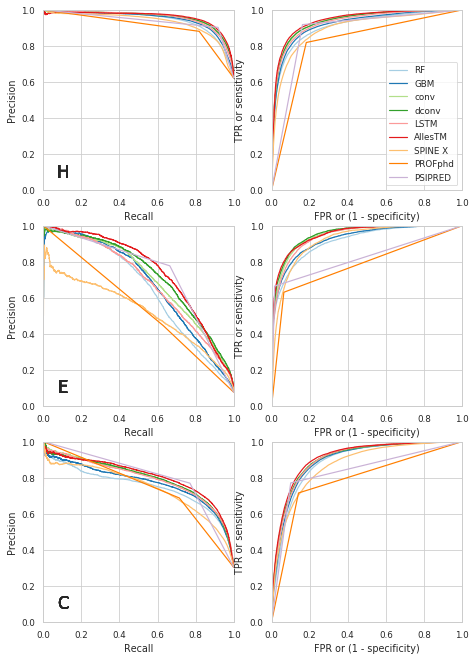

In [367]:
 plots_cat(sec_cat, {"cat": sec_cat}, filename='sec_cat', class_names=['H', 'E', 'C'])

# Secondary structure WITHOUT TMS

In [368]:
sec_cat_notms = pd.read_sql_query(f"select p.experiment, p.resi, p.val_0, p.val_1, p.val_2 from mllib_features_categorical_SecStruc as p join raw_data using (id, resi) join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where topo!='T' and topo !='R' and experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)


<h3>Data description</h3>

In [369]:
sec_cat_notms.groupby("experiment").describe()

resi                                                   \
                count        mean         std  min   25%    50%    75%   
experiment                                                               
blending_sec  31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   
cnn_sec       31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   
dcnn_sec      31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   
lstm_sec      31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   
observed      31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   
prof          31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   
psipred       31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   
rf_sec        31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   
spinex_sec    31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   
xgb_sec       31612.0  220.641339  180.305607  0.0  86.0  178.0  306.0   

                        val_0            ...     val_1              val_2  \
                 max    count      mean  ...       75%       max    count   
experiment                               ...                                
blending_sec  1045.0  31612.0  0.426330  ...  0.096221  0.975391  31612.0   
cnn_sec       1045.0  31612.0  0.406199  ...  0.120484  0.999758  31612.0   
dcnn_sec      1045.0  31612.0  0.428450  ...  0.116101  0.998300  31612.0   
lstm_sec      1045.0  31612.0  0.421677  ...  0.093589  0.998870  31612.0   
observed      1045.0  31612.0  0.416740  ...  0.000000  1.000000  31612.0   
prof          1045.0  31612.0  0.393173  ...  0.000000  1.000000  31612.0   
psipred       1045.0  31612.0  0.422150  ...  0.000000  1.000000  31612.0   
rf_sec        1045.0  31612.0  0.466396  ...  0.122323  0.921932  31612.0   
spinex_sec    1045.0  31612.0  0.430340  ...  0.096900  0.935900  31612.0   
xgb_sec       1045.0  31612.0  0.443398  ...  0.060858  0.998010  31612.0   

                                                                          \
                  mean       std       min       25%       50%       75%   
experiment                                                                 
blending_sec  0.436419  0.334223  0.009677  0.075412  0.421096  0.793406   
cnn_sec       0.451875  0.339274  0.000081  0.095285  0.450750  0.779805   
dcnn_sec      0.436886  0.339544  0.000389  0.083147  0.417981  0.769258   
lstm_sec      0.458919  0.332035  0.000156  0.109169  0.471936  0.780210   
observed      0.457010  0.498156  0.000000  0.000000  0.000000  1.000000   
prof          0.476465  0.499454  0.000000  0.000000  0.000000  1.000000   
psipred       0.470106  0.499113  0.000000  0.000000  0.000000  1.000000   
rf_sec        0.428374  0.224103  0.000000  0.239239  0.429204  0.606667   
spinex_sec    0.424846  0.350574  0.025500  0.062100  0.341350  0.819300   
xgb_sec       0.469443  0.351777  0.000055  0.096970  0.472686  0.815955   

                        
                   max  
experiment              
blending_sec  0.912146  
cnn_sec       0.999999  
dcnn_sec      0.998175  
lstm_sec      0.997412  
observed      1.000000  
prof          1.000000  
psipred       1.000000  
rf_sec        0.976667  
spinex_sec    0.937900  
xgb_sec       0.999711  

[10 rows x 32 columns]

<h3>Benchmark measures</h3>

In [370]:
measures_cat(sec_cat_notms, 3, class_names=['H', 'E', 'C'], filename='sec_cat_notms')

,ACC,H (P),H (R),H (F1),H (AUC),H (MCC),E (P),E (R),E (F1),E (AUC),E (MCC),C (P),C (R),C (F1),C (AUC),C (MCC)
RF,0.71,0.68,0.79,0.73,0.76,0.52,0.94,0.23,0.37,0.61,0.44,0.72,0.77,0.74,0.76,0.52
GBM,0.74,0.76,0.77,0.76,0.8,0.59,0.84,0.44,0.58,0.71,0.57,0.72,0.8,0.76,0.77,0.54
conv,0.76,0.81,0.77,0.79,0.82,0.65,0.67,0.62,0.65,0.79,0.6,0.74,0.79,0.77,0.78,0.56
dconv,0.77,0.8,0.79,0.8,0.82,0.65,0.7,0.63,0.66,0.79,0.62,0.75,0.78,0.77,0.78,0.56
LSTM,0.75,0.79,0.77,0.78,0.81,0.62,0.72,0.54,0.62,0.76,0.58,0.73,0.8,0.77,0.78,0.55
AllesTM,0.78,0.81,0.8,0.81,0.83,0.67,0.73,0.65,0.69,0.81,0.65,0.76,0.79,0.78,0.79,0.58
SPINE X,0.73,0.76,0.79,0.77,0.8,0.61,0.6,0.56,0.58,0.75,0.52,0.74,0.73,0.73,0.75,0.51
PROFphd,0.73,0.78,0.74,0.76,0.8,0.6,0.61,0.63,0.62,0.78,0.56,0.72,0.76,0.74,0.76,0.51
PSIPRED,0.8,0.83,0.84,0.83,0.86,0.71,0.78,0.67,0.72,0.82,0.69,0.79,0.81,0.8,0.81,0.62


<h3>Benchmark plots</h3>

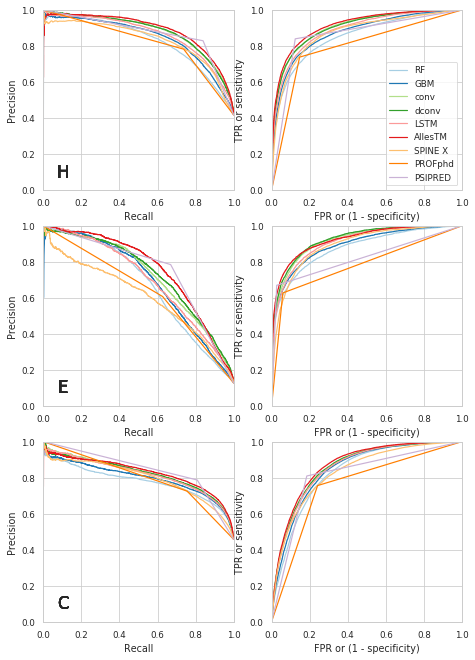

In [371]:
 plots_cat(sec_cat_notms, {"cat": sec_cat_notms}, filename='sec_cat_notms', class_names=['H', 'E', 'C'])

# RSA

<h2>RSA complex</h2>

In [372]:
rsa_comp_cont = pd.read_sql_query(f"select * from mllib_features_continuous_RsaComplex join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [373]:
rsa_comp_cont.groupby("experiment").describe()

resi                                            \
                        count        mean         std  min   25%    50%   
experiment                                                                
blending_rsa_complex  56089.0  208.356237  175.068148  0.0  79.0  166.0   
cnn_domain_rsa        56089.0  208.356237  175.068148  0.0  79.0  166.0   
dcnn_domain_rsa       56089.0  208.356237  175.068148  0.0  79.0  166.0   
lstm_domain_rsa       56089.0  208.356237  175.068148  0.0  79.0  166.0   
observed              56089.0  208.356237  175.068148  0.0  79.0  166.0   
rf_rsa_complex        56089.0  208.356237  175.068148  0.0  79.0  166.0   
spinex_rsa            56089.0  208.356237  175.068148  0.0  79.0  166.0   
xgb_rsa_complex       56089.0  208.356237  175.068148  0.0  79.0  166.0   

                                       val_0                                \
                        75%     max    count      mean       std       min   
experiment                                                                   
blending_rsa_complex  287.0  1045.0  56089.0  0.267518  0.172644 -0.045392   
cnn_domain_rsa        287.0  1045.0  56089.0  0.240557  0.190473 -0.065167   
dcnn_domain_rsa       287.0  1045.0  56089.0  0.246432  0.193139 -0.056883   
lstm_domain_rsa       287.0  1045.0  56089.0  0.239893  0.191213 -0.146562   
observed              287.0  1045.0  56089.0  0.268685  0.251495  0.000000   
rf_rsa_complex        287.0  1045.0  56089.0  0.271969  0.129532  0.008805   
spinex_rsa            287.0  1045.0  56089.0  0.208860  0.144279  0.004930   
xgb_rsa_complex       287.0  1045.0  56089.0  0.269614  0.151748 -0.057928   

                                                              
                           25%       50%       75%       max  
experiment                                                    
blending_rsa_complex  0.116616  0.242953  0.399270  1.009346  
cnn_domain_rsa        0.064470  0.211918  0.381830  1.179458  
dcnn_domain_rsa       0.073148  0.215583  0.389716  1.271654  
lstm_domain_rsa       0.069966  0.208872  0.380048  1.137749  
observed              0.038462  0.201220  0.452381  1.000000  
rf_rsa_complex        0.165252  0.257674  0.372203  0.752731  
spinex_rsa            0.100769  0.166667  0.283962  0.828293  
xgb_rsa_complex       0.145661  0.252954  0.383111  0.878451

<h3>Benchmark measures</h3>

In [374]:
measures_cont(rsa_comp_cont, filename='rsa_comp_cont')

,r,MAE,MSE,RMSE
RF,0.6,0.16,0.04,0.2
GBM,0.63,0.15,0.04,0.19
conv,0.63,0.15,0.04,0.2
dconv,0.63,0.15,0.04,0.2
LSTM,0.63,0.15,0.04,0.2
AllesTM,0.67,0.14,0.04,0.19
SPINE X,0.54,0.17,0.05,0.22


<h3>Benchmark plots</h3>

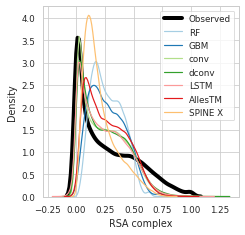

In [375]:
plots_cont(rsa_comp_cont, "RSA complex", "Density", filename='rsa_comp_cont')

# RSA chain

In [376]:
rsa_chain_cont = pd.read_sql_query(f"select * from mllib_features_continuous_RsaChain join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [377]:
rsa_chain_cont.groupby("experiment").describe()

resi                                                   \
                      count        mean         std  min   25%    50%    75%   
experiment                                                                     
blending_rsa_chain  56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
cnn_domain_rsa      56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
dcnn_domain_rsa     56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
lstm_domain_rsa     56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
observed            56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
rf_rsa_chain        56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
spinex_rsa          56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
xgb_rsa_chain       56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   

                              val_0                                          \
                       max    count      mean       std       min       25%   
experiment                                                                    
blending_rsa_chain  1045.0  56089.0  0.313246  0.179047 -0.069565  0.162420   
cnn_domain_rsa      1045.0  56089.0  0.283543  0.199395 -0.053244  0.101810   
dcnn_domain_rsa     1045.0  56089.0  0.290010  0.202661 -0.092844  0.109744   
lstm_domain_rsa     1045.0  56089.0  0.286676  0.200069 -0.168121  0.111930   
observed            1045.0  56089.0  0.321574  0.265701  0.000000  0.070423   
rf_rsa_chain        1045.0  56089.0  0.323961  0.122975  0.016782  0.229419   
spinex_rsa          1045.0  56089.0  0.208860  0.144279  0.004930  0.100769   
xgb_rsa_chain       1045.0  56089.0  0.322384  0.153660 -0.062835  0.203317   

                                                  
                         50%       75%       max  
experiment                                        
blending_rsa_chain  0.301835  0.448829  1.033235  
cnn_domain_rsa      0.271639  0.436059  1.258072  
dcnn_domain_rsa     0.275533  0.444537  1.268936  
lstm_domain_rsa     0.273717  0.437911  1.267692  
observed            0.285714  0.526627  1.000000  
rf_rsa_chain        0.321514  0.417637  0.764406  
spinex_rsa          0.166667  0.283962  0.828293  
xgb_rsa_chain       0.320738  0.435437  0.898925

<h3>Benchmark measures</h3>

In [378]:
measures_cont(rsa_chain_cont, filename='rsa_chain_cont')

,r,MAE,MSE,RMSE
RF,0.58,0.18,0.05,0.22
GBM,0.62,0.17,0.04,0.21
conv,0.59,0.17,0.05,0.22
dconv,0.61,0.16,0.05,0.22
LSTM,0.61,0.16,0.05,0.22
AllesTM,0.65,0.16,0.04,0.2
SPINE X,0.51,0.19,0.07,0.26


<h3>Benchmark plots</h3>

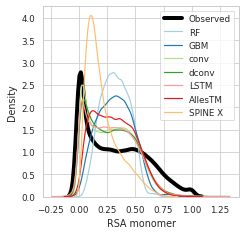

In [379]:
plots_cont(rsa_chain_cont, "RSA monomer", "Density", filename='rsa_chain_cont')

# RSA diff

In [380]:
rsa_diff_cont = pd.read_sql_query(f"select * from mllib_features_continuous_RsaDiff join (select distinct id from datasets where name='{dataset_name}' and kind='{kind}') a using (id) where experiment not like '%_VALID_%' and experiment not like '%_IND_TEST_%' order by experiment, id, resi", conn)

<h3>Data description</h3>

In [381]:
rsa_diff_cont.groupby("experiment").describe()

resi                                                   \
                     count        mean         std  min   25%    50%    75%   
experiment                                                                    
blending_rsa_diff  56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
cnn_domain_rsa     56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
dcnn_domain_rsa    56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
lstm_domain_rsa    56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
observed           56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
rf_rsa_diff        56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   
xgb_rsa_diff       56089.0  208.356237  175.068148  0.0  79.0  166.0  287.0   

                             val_0                                          \
                      max    count      mean       std       min       25%   
experiment                                                                   
blending_rsa_diff  1045.0  56089.0  0.045790  0.046120 -0.101630  0.018655   
cnn_domain_rsa     1045.0  56089.0  0.000830  0.003315 -0.039915 -0.000527   
dcnn_domain_rsa    1045.0  56089.0  0.003404  0.012039 -0.051069 -0.001657   
lstm_domain_rsa    1045.0  56089.0  0.003605  0.017703 -0.025706 -0.000243   
observed           1045.0  56089.0  0.052889  0.137463  0.000000  0.000000   
rf_rsa_diff        1045.0  56089.0  0.056439  0.033978  0.000665  0.031395   
xgb_rsa_diff       1045.0  56089.0  0.053839  0.038102 -0.012126  0.028609   

                                                 
                        50%       75%       max  
experiment                                       
blending_rsa_diff  0.035559  0.062167  0.514298  
cnn_domain_rsa     0.000426  0.001718  0.062540  
dcnn_domain_rsa    0.000127  0.005675  0.161556  
lstm_domain_rsa    0.000748  0.002506  0.523616  
observed           0.000000  0.000000  1.000000  
rf_rsa_diff        0.050528  0.074691  0.365622  
xgb_rsa_diff       0.044169  0.068169  0.469332

<h3>Benchmark measures</h3>

In [382]:
measures_cont(rsa_diff_cont, filename='rsa_diff_cont')

,r,MAE,MSE,RMSE
RF,0.27,0.08,0.02,0.13
GBM,0.3,0.08,0.02,0.13
conv,0.09,0.05,0.02,0.15
dconv,0.11,0.06,0.02,0.15
LSTM,0.12,0.05,0.02,0.15
AllesTM,0.29,0.08,0.02,0.13


<h3>Benchmark plots</h3>

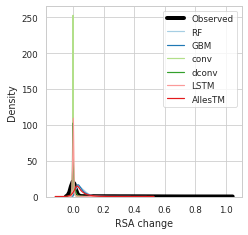

In [383]:
plots_cont(rsa_diff_cont, "RSA change", "Density", filename='rsa_diff_cont')

# Others

In [384]:
history = json.loads(conn.cursor().execute('select history from experiments where experiment="keras_all_targets" and fold=0').fetchone()[0])
history.keys()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
plt.plot(range(len(history['loss'])), history['loss'])
plt.plot(range(len(history['val_loss'])), history['val_loss'])
plt.plot(range(len(history['lr'])), np.log(history['lr']) - np.min(np.log(history['lr'])))

In [ ]:
import sys
sys.path.append('..')

In [ ]:
from mllib.features.continuous import Pssm, Pssm2
from mllib.retrievers import SQLRetriever

In [ ]:
vals = []
vals2 = []
for idx in conn.cursor().execute('select id from alignments limit 20'):
    print(idx)
    #vals.extend(Pssm().transform(SQLRetriever(conn, Pssm.query).transform(idx[0])).flatten())
    #vals2.extend(Pssm2().transform(SQLRetriever(conn, Pssm.query).transform(idx[0])).flatten())
    
#msa = SQLRetriever(conn, Pssm.query).transform('1kpl_B')
#%time Pssm().transform(msa)

In [ ]:
len(vals), len(vals2)

In [ ]:
vals = np.array(vals)
vals2 = np.array(vals2)

In [ ]:
def normalize(xs):
    return list(map(lambda x: 1 / (1 + np.exp(-1 * x)), xs))
                
hist = True
kde = False
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(vals / 2 + 0.5, label='pssm', hist=hist, kde=kde, ax=axs[0])
sns.distplot(vals2, label='pssm2', hist=hist, kde=kde, ax=axs[1])
plt.legend()

In [ ]:
xxx = pd.read_sql_query('select phi, psi from raw_data', conn)

In [ ]:
xxx.describe()

In [ ]:
print(math.pi)